
# Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import re
import string
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Load and Prepare the Dataset

In [31]:
df = pd.read_csv("training_data_lowercase.csv", sep='\t', header=None)
df.columns = ['label', 'text']


# Custom Stopwords and Preprocessing Function

In [ ]:
stopwords_custom = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'that', 'it', 'on', 'for', 'with',
    'as', 'was', 'at', 'by', 'an', 'be', 'this', 'from', 'or', 'are', 'but',
    'not', 'have', 'they', 'you', 'we', 'has', 'had', 'were', 'which', 'their',
    'would', 'there', 'what', 'when', 'who', 'will', 'one', 'all', 'can', 'if',
    'about', 'more', 'just', 'up', 'out', 'so', 'no', 'into', 'do', 'than', 'your'
])

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stopwords_custom and len(w) > 2]
    return ' '.join(words)


# Apply Preprocessing and Split Data

In [34]:
df['clean_text'] = df['text'].apply(preprocess)
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)


# TF-IDF Vectorization

In [35]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Train Naive Bayes

In [36]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
pred_nb = nb.predict(X_test_tfidf)


# Train Random Forest

In [37]:
rf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42)
rf.fit(X_train_tfidf, y_train)
pred_rf = rf.predict(X_test_tfidf)


# Train Logistic Regression

In [38]:
lr = LogisticRegression(C=10, max_iter=1000)
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)


# Train XGBoost Classifier

In [39]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train)
pred_xgb = xgb.predict(X_test_tfidf)

c:\Users\Zahinos\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:59:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



# Evaluation Reports

In [40]:
report_nb = classification_report(y_test, pred_nb, target_names=['fake', 'real'], output_dict=True, zero_division=0)
report_rf = classification_report(y_test, pred_rf, target_names=['fake', 'real'], output_dict=True, zero_division=0)
report_lr = classification_report(y_test, pred_lr, target_names=['fake', 'real'], output_dict=True, zero_division=0)
report_xgb = classification_report(y_test, pred_xgb, target_names=['fake', 'real'], output_dict=True, zero_division=0)


# Model Comparison

In [41]:
comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, pred_nb),
        accuracy_score(y_test, pred_rf),
        accuracy_score(y_test, pred_lr),
        accuracy_score(y_test, pred_xgb)
    ],
    'Fake_Precision': [report_nb['fake']['precision'], report_rf['fake']['precision'], report_lr['fake']['precision'], report_xgb['fake']['precision']],
    'Fake_Recall': [report_nb['fake']['recall'], report_rf['fake']['recall'], report_lr['fake']['recall'], report_xgb['fake']['recall']],
    'Fake_F1-score': [report_nb['fake']['f1-score'], report_rf['fake']['f1-score'], report_lr['fake']['f1-score'], report_xgb['fake']['f1-score']],
    'Real_Precision': [report_nb['real']['precision'], report_rf['real']['precision'], report_lr['real']['precision'], report_xgb['real']['precision']],
    'Real_Recall': [report_nb['real']['recall'], report_rf['real']['recall'], report_lr['real']['recall'], report_xgb['real']['recall']],
    'Real_F1-score': [report_nb['real']['f1-score'], report_rf['real']['f1-score'], report_lr['real']['f1-score'], report_xgb['real']['f1-score']]
}).sort_values(by='Accuracy', ascending=False)

print(comparison_df)

                 Model  Accuracy  Fake_Precision  Fake_Recall  Fake_F1-score  \
2  Logistic Regression  0.942468        0.949284     0.938793       0.944009   
0          Naive Bayes  0.933538        0.932489     0.939360       0.935912   
3              XGBoost  0.884351        0.948282     0.820912       0.880012   
1        Random Forest  0.875860        0.925961     0.825730       0.872978   

   Real_Precision  Real_Recall  Real_F1-score  
2        0.935349     0.946396       0.940840  
0        0.934676     0.927317       0.930982  
3        0.832627     0.952150       0.888387  
1        0.833062     0.929437       0.878614  



# Plot Confusion Matrices

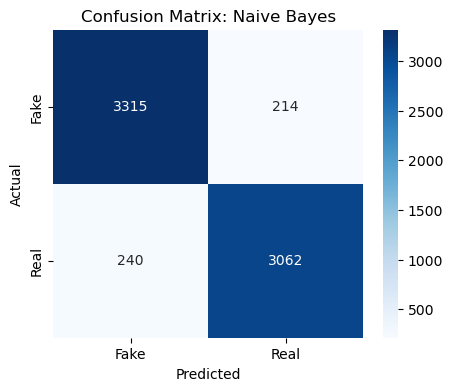

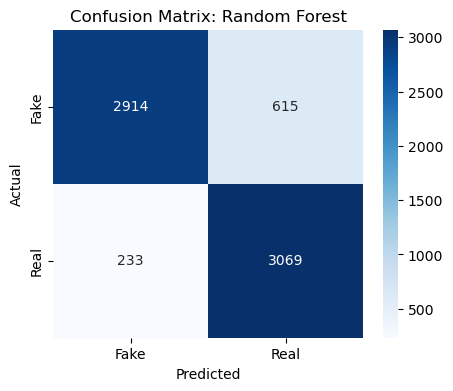

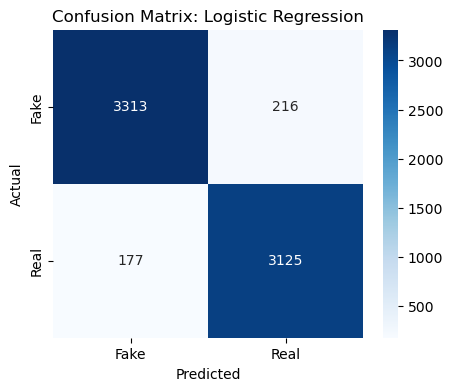

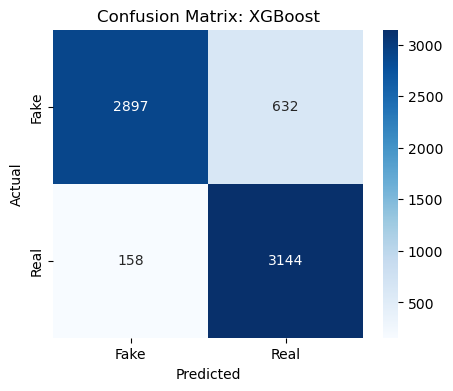

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Visualizar cada modelo
plot_conf_matrix(y_test, pred_nb, 'Naive Bayes')
plot_conf_matrix(y_test, pred_rf, 'Random Forest')
plot_conf_matrix(y_test, pred_lr, 'Logistic Regression')
plot_conf_matrix(y_test, pred_xgb, 'XGBoost')


# Accuracy Comparison Bar Plot

C:\Users\Zahinos\AppData\Local\Temp\ipykernel_1464\2437374434.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=comparison_df, palette='viridis')


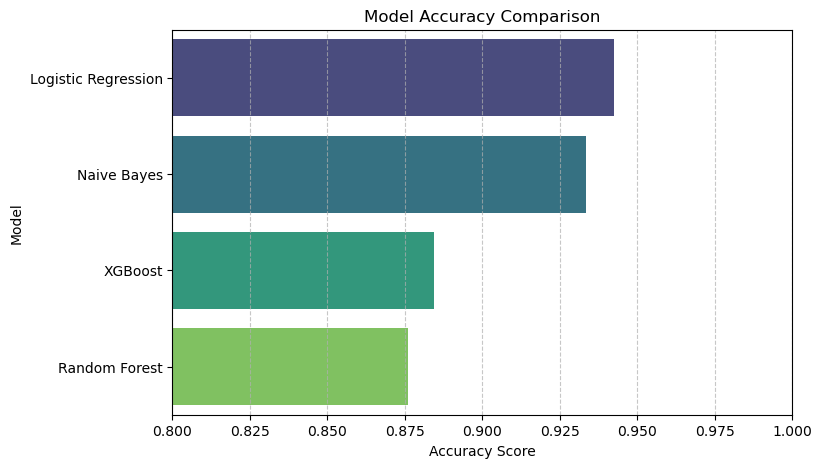

In [43]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Accuracy', y='Model', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0.8, 1.0)
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
